# Handwritten Digit Recognition using PyTorch

In this project, we will develop a machine learning model to classify handwritten digits using the **MNIST** dataset. The dataset contains images of digits (0-9) written by different people. Our goal is to build a deep learning model using **PyTorch** that can accurately classify these images.

The project involves several key steps:
1. **Data Loading and Preprocessing**: We will load the MNIST dataset and apply necessary transformations, such as normalizing the images and splitting them into training, validation, and test sets.
2. **Model Construction**: A neural network will be built using PyTorch, with layers such as Fully Connected layers and ReLU activation functions.
3. **Model Training**: We will train the model using the training dataset and evaluate its performance.
4. **Model Evaluation**: The trained model will be evaluated on the test dataset, and we will track its accuracy and other performance metrics.

This project will help you understand the process of building and training a deep learning model, from data preprocessing to model evaluation.


In [85]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check if GPU is available and move model and data accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set random seed for reproducibility
seed = 42  # You can use any number for the seed

# Set the seed for various libraries
torch.manual_seed(seed)  # Set the seed for CPU
torch.cuda.manual_seed(seed)  # Set the seed for GPU
torch.cuda.manual_seed_all(seed)  # For all GPUs (if you're using more than one GPU)
np.random.seed(seed)  # Set the seed for numpy
random.seed(seed)  # Set the seed for Python random library

# Ensuring deterministic behavior in CUDA (optional, but helps in reproducibility)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


cuda


# Step 1: Data Loading and Preparation

In this step, we will load the MNIST dataset, which contains images of handwritten digits from 0 to 9. The dataset will be split into training, validation, and test sets.

We will use the `torchvision` library to load the dataset and apply necessary transformations like converting the images to tensors and normalizing them.

Let's load and explore the dataset.


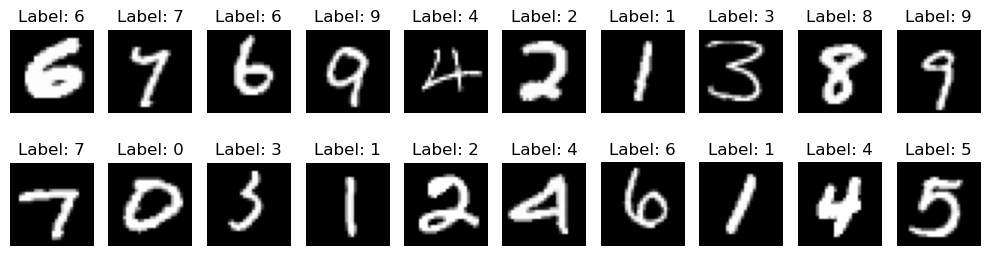

In [86]:
# Apply a sequence of transformations: 
# 1. Convert images to Tensor and normalize pixel values to the range [0, 1].
# 2. Normalize the Tensor to have a mean of 0.5 and a standard deviation of 0.5.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


#Split the training data into training and validation datasets (80% train, 20% validation)
train_data, val_data = torch.utils.data.random_split(train_data, [int(0.8 * len(train_data)), int(0.2 * len(train_data))])


# Create DataLoader for training and testing
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Visualizing the first 20 images in the training dataset
plt.figure(figsize=(10, 3))
for i in range(20):
    image, label = train_data[i]
    plt.subplot(2, 10, i+1)  # Create a grid of 2 rows and 10 columns
    plt.imshow(image.squeeze(), cmap="gray") # Squeeze the image to remove the channel dimension (if the image is in (1, 28, 28) format)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Turn off axis for better visualization

plt.tight_layout() 
plt.show()

# Step 2: Model Construction

This model is a fully connected neural network for classifying the MNIST handwritten digit dataset. It incorporates advanced techniques such as Batch Normalization, Dropout, and Softmax to improve the model's performance and prevent overfitting.

### Model Architecture:
1. **Input Layer**: 
   - The input is a 28x28 image, flattened into a vector of size 784.
   
2. **Hidden Layer 1**: 
   - 128 neurons with **Batch Normalization** applied to stabilize the training.
   - **ReLU** activation function introduces non-linearity.
   - **Dropout** (0.3) is used to prevent overfitting.

3. **Hidden Layer 2**:
   - 64 neurons with **Batch Normalization**.
   - **ReLU** activation function and **Dropout** (0.3) to reduce overfitting.

4. **Output Layer**:
   - 10 neurons corresponding to the 10 digit classes (0-9).
   - **Softmax** activation function for multi-class classification, outputting probabilities for each class.

### Key Techniques:
- **Batch Normalization**: Helps to normalize the output of previous layers to improve training speed and stability.
- **Dropout**: Randomly drops a fraction of input units to prevent overfitting.
- **Softmax**: Converts the raw output into probabilities for classification.

This architecture aims to provide better generalization and robustness when trained on the MNIST dataset.



In [87]:
class HandwrittenDigitModel(nn.Module):
    def __init__(self):
        super(HandwrittenDigitModel, self).__init__()
        # Layer 1: 28*28 input to 128 neurons
        self.fc1 = nn.Linear(28*28, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Normalization for the first layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout to prevent overfitting
        
        # Layer 2: 128 neurons to 64 neurons
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   # Batch Normalization for the second layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout to prevent overfitting
        
        # Output layer: 64 neurons to 10 (for 10 classes: digits 0-9)
        self.fc3 = nn.Linear(64, 10)
        
        # ReLU activation and Softmax for multi-class classification
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class output
        
    def forward(self, x):
        # Flatten the image from (28, 28) to (28*28)
        x = x.reshape(-1, 28*28)
        
        # Layer 1: fully connected + Batch Normalization + ReLU + Dropout
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        # Layer 2: fully connected + Batch Normalization + ReLU + Dropout
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        # Output layer: fully connected + Softmax for multi-class classification
        x = self.fc3(x)
        x = self.softmax(x)
        return x
# Instantiate the model
model = HandwrittenDigitModel()
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


HandwrittenDigitModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


### Train and Validate on GPU

To speed up the training process, we will move the model and data to the GPU if it is available. This will allow us to take advantage of the GPU's parallel processing capabilities.


In [88]:
model.to(device)  # Move model to GPU

# Move data to GPU within the training loop
def move_to_device(data, device):
    images, labels = data
    return images.to(device), labels.to(device)

### Step 3: Training and Validation

In this step, we will train our model, track its performance on both training and validation datasets, and store the loss and accuracy values for visualization. We will:
- Train the model for a specified number of epochs.
- Calculate the loss and accuracy on the training and validation sets.
- Store these metrics for later visualization.

In [89]:
# Number of epochs
num_epochs = 10

# Store loss and accuracy values for visualization
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables to keep track of the best accuracy and corresponding epoch
best_accuracy = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0 # Initialize running_loss to 0 at the beginning of each epoch to accumulate loss for that epoch.
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        # Move data to GPU
        images, labels = move_to_device((images, labels), device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad() # Zero the gradients to prevent accumulation from previous batches.
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Track training accuracy
        _, predicted = torch.max(outputs, 1) # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0) # Update the total number of training samples processed in the current epoch
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to GPU
            images, labels = move_to_device((images, labels), device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            # Track validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1
        

os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/best-model')
print('------------------------------------')
print(f"Best model saved at epoch {best_epoch} with accuracy: {best_accuracy:.2f}%")



Epoch [1/10] - Train Loss: 1.6467, Train Accuracy: 86.24% - Val Loss: 1.5324, Val Accuracy: 93.64%
Epoch [2/10] - Train Loss: 1.5443, Train Accuracy: 92.60% - Val Loss: 1.5160, Val Accuracy: 94.87%
Epoch [3/10] - Train Loss: 1.5297, Train Accuracy: 93.80% - Val Loss: 1.5062, Val Accuracy: 95.67%
Epoch [4/10] - Train Loss: 1.5202, Train Accuracy: 94.53% - Val Loss: 1.5026, Val Accuracy: 96.02%
Epoch [5/10] - Train Loss: 1.5154, Train Accuracy: 94.93% - Val Loss: 1.4987, Val Accuracy: 96.35%
Epoch [6/10] - Train Loss: 1.5122, Train Accuracy: 95.17% - Val Loss: 1.4958, Val Accuracy: 96.66%
Epoch [7/10] - Train Loss: 1.5090, Train Accuracy: 95.53% - Val Loss: 1.4951, Val Accuracy: 96.66%
Epoch [8/10] - Train Loss: 1.5056, Train Accuracy: 95.83% - Val Loss: 1.4944, Val Accuracy: 96.79%
Epoch [9/10] - Train Loss: 1.5057, Train Accuracy: 95.74% - Val Loss: 1.4945, Val Accuracy: 96.77%
Epoch [10/10] - Train Loss: 1.5039, Train Accuracy: 95.96% - Val Loss: 1.4921, Val Accuracy: 96.98%
---------


# Plot the Training and Validation Loss

The following plot displays the training and validation loss over the epochs. This visualization helps track the model's 

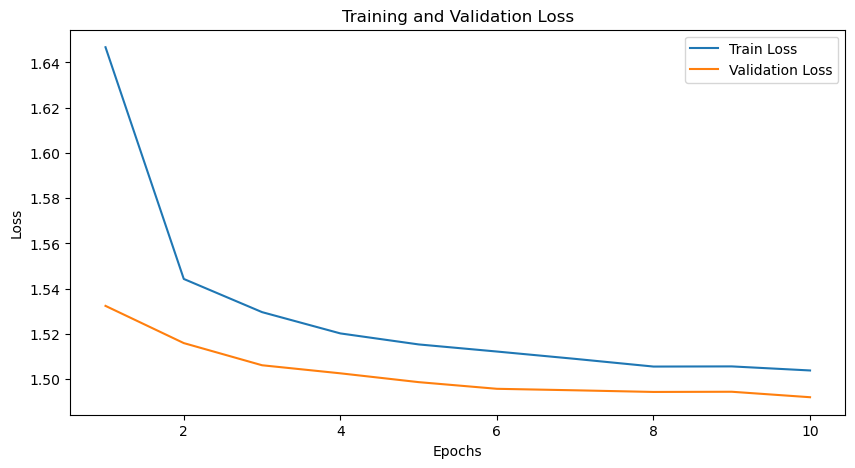

In [90]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Confusion Matrix for Validation Data

This code helps to load a pre-trained model, evaluate its performance on the validation dataset, and visualize the results using a confusion matrix.

### Process Overview

1. **Load the pre-trained model**:
   - The model `HandwrittenDigitModel` is instantiated.
   - Pre-trained weights are loaded from a file located at `./models/best-model`.
   - The model is moved to the appropriate device (CPU/GPU).
   - The model is set to **evaluation mode** using `model.eval()` to disable gradient computation during inference.

2. **Prepare for inference**:
   - **Initialize variables** `all_preds` and `all_labels` to store the predicted and true labels for each image in the validation dataset.
   - Disable gradient computation with `torch.no_grad()` to save memory and speed up inference.

3. **Loop through the validation dataset** (`val_loader`):
   - Move images and labels to the appropriate device.
   - Perform a **forward pass** through the model to get the predicted class probabilities.
   - **Find the predicted class** by taking the index of the highest probability using `torch.max`.
   - Store the predictions and true labels in `all_preds` and `all_labels` respectively.

4. **Generate the confusion matrix**:
   - After processing all validation data, convert the lists `all_preds` and `all_labels` to NumPy arrays.
   - Compute the **confusion matrix** using `confusion_matrix` from `sklearn`.

5. **Plot the confusion matrix**:
   - The confusion matrix is visualized using **seaborn's heatmap**.
   - The x-axis shows the predicted labels, and the y-axis shows the true labels. The matrix cells display the count of occurrences for each true-predicted label pair.



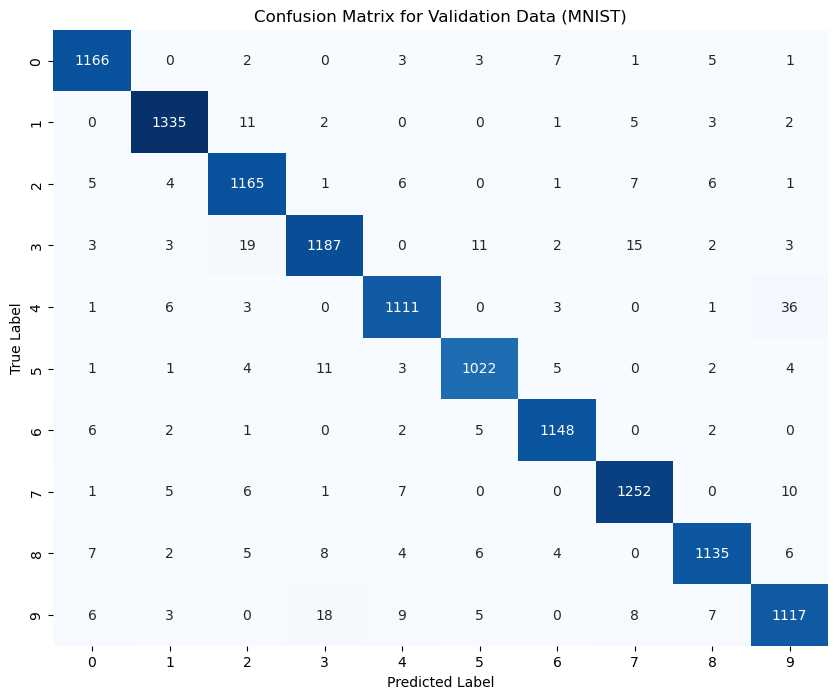

In [91]:
model = HandwrittenDigitModel()
model.load_state_dict(torch.load('./models/best-model', weights_only=True))
model.to(device) 
model.eval()

# Initialize variables to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for images, labels in val_loader:
        # Move data to device (GPU/CPU)
        images, labels = move_to_device((images, labels), device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted class (index with max probability)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix for Validation Data (MNIST)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Misclassified Images Visualization

This code helps to identify and visualize misclassified images from the validation dataset. The process is as follows:

1. **Create a dictionary** `misclassified_images` to store misclassified images for each class label (0-9). Each key represents the true class label, and the value is a list of tuples containing the misclassified image and its predicted label.
   
2. **Loop through the validation dataset** (`val_loader`) and for each image:
   - Move images and labels to the appropriate device (CPU/GPU).
   - Perform a **forward pass** through the model to get the predictions.
   - **Compare the predicted labels** with the true labels. If they are not equal (misclassification), the image is added to the dictionary under the corresponding true label.

3. **Display one misclassified image for each class**:
   - A 2x5 grid of subplots is created to display the images.
   - For each class (0-9), the first misclassified image is displayed with its true and predicted labels as titles.
   - If there are no misclassified images for a particular class, a message `No errors for class X` is shown, and the axis is hidden.

4. The **misclassified images** are displayed using `matplotlib`.

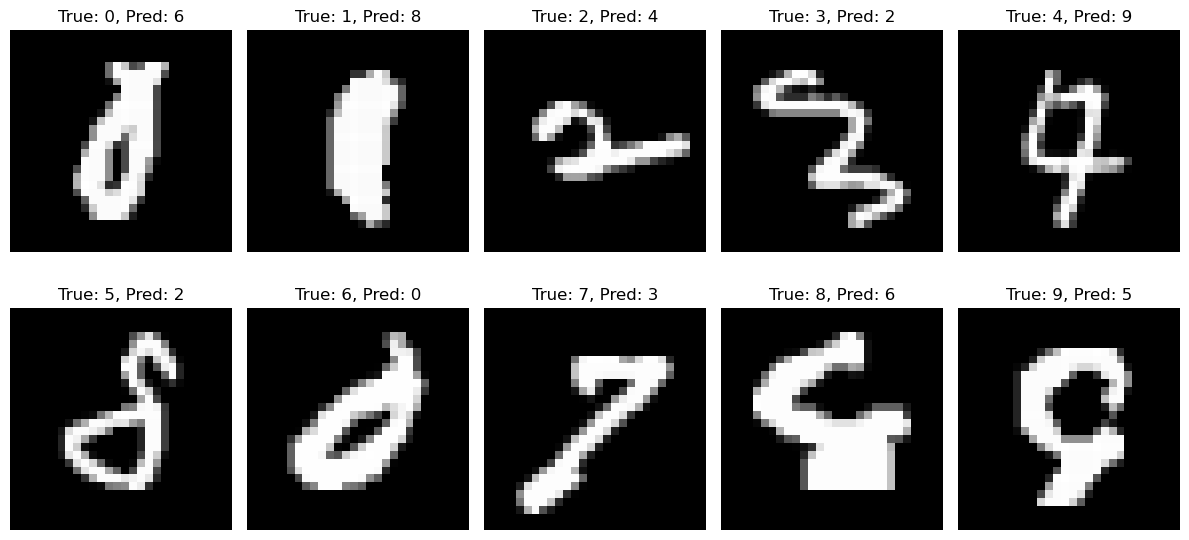

In [93]:
# Create a dictionary to store misclassified images
misclassified_images = {i: [] for i in range(10)}  # Key: True class label

# Add misclassified images to the dictionary
with torch.no_grad():
    for images, labels in val_loader:
        # Move images and labels to the appropriate device
        images, labels = move_to_device((images, labels), device)
        
        # Perform forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted labels
        
        # Compare predictions with true labels
        for img, true_label, pred_label in zip(images.cpu(), labels.cpu(), preds.cpu()):
            if true_label != pred_label:  # If the prediction is incorrect
                misclassified_images[true_label.item()].append((img, pred_label.item()))

# Display one misclassified image for each class
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # Create a 2x5 grid for displaying images
axes = axes.flatten()

for i in range(10):  # Iterate over all classes (0-9)
    if len(misclassified_images[i]) > 0:
        img, pred_label = misclassified_images[i][0]  # Take the first misclassified example
        axes[i].imshow(img.squeeze(), cmap="gray")  # Display the image
        axes[i].set_title(f"True: {i}, Pred: {pred_label}")  # Show true and predicted labels
        axes[i].axis("off")  # Turn off axis for better visualization
    else:
        axes[i].axis("off")  # Hide axis if no errors exist for this class
        axes[i].set_title(f"No errors for class {i}")  # Show a message if no errors exist

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Step 4: Evaluate Model on Test Set

This code evaluates the model's performance on the test set by calculating the accuracy. Here's a step-by-step breakdown:

1. **Initialize variables** to track the number of correct predictions (`correct_test`) and total predictions (`total_test`).
2. **Set the model to evaluation mode** (`model.eval()`), which disables gradient calculations.
3. **Disable gradient calculation** using `torch.no_grad()` for inference, ensuring no gradients are computed during the forward pass.
4. Loop through the **test dataset** (`test_loader`) and:
   - Move images and labels to the appropriate device (CPU/GPU).
   - Perform the **forward pass** with the model to get predictions.
   - Use `torch.max` to obtain the predicted labels by selecting the index with the highest probability.
   - Update the `correct_test` and `total_test` variables based on the comparison of predictions with true labels.
5. After the loop, the **test accuracy** is calculated by dividing the number of correct predictions by the total predictions, then multiplying by 100 to get a percentage.
6. The **test accuracy** is printed.

In [94]:
# Initialize variables to track the number of correct predictions and total predictions
correct_test = 0
total_test = 0

# Set the model to evaluation mode (no gradient calculations)
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the appropriate device (CPU/GPU)
        images, labels = move_to_device((images, labels), device)
        
        # Perform forward pass
        outputs = model(images)
        
        # Get the predicted labels by taking the index with the highest probability
        _, preds = torch.max(outputs, 1)
        
        # Update the number of correct predictions and total predictions
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

# Calculate accuracy
test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 97.06%
